In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 
import random
import copy
import cv2

In [172]:
inputImage = cv2.imread('./panamericana1.PNG', 0)
objectiveImage = cv2.imread('./panamericana2.PNG', 0)

inputImage = cv2.threshold(inputImage, 200, 255, cv2.THRESH_BINARY)[1]
objectiveImage = cv2.threshold(objectiveImage, 200, 255, cv2.THRESH_BINARY)[1]

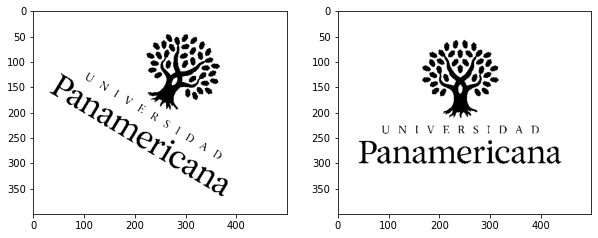

In [173]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(inputImage.astype(np.uint8), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(objectiveImage.astype(np.uint8), cmap='gray')

In [174]:
def objectiveFunction(img1):
    return np.sum((objectiveImage - img1) ** 2)

In [175]:
# Rotate Test
(h, w) = inputImage.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 30.5, 1.0)
rotated = cv2.warpAffine(inputImage, M, (w, h), borderValue=(255,255,255))
#cv2.imshow("Rotated by 45 Degrees", rotated)

640701


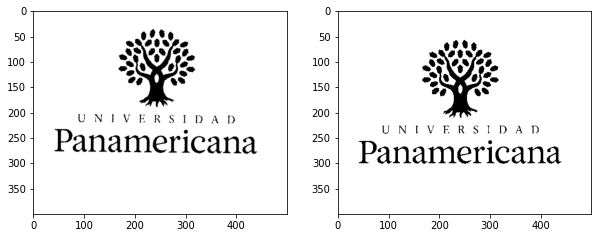

In [176]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rotated, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(objectiveImage, cmap='gray')

print(objectiveFunction(rotated))

### Genetic Algorithm Aux Functions

In [177]:
imageHeight = inputImage.shape[0]
imageWidth = inputImage.shape[1]

In [178]:
class Chromosome:
    #dX = dy = dt = da = sX = sY = st = sa = 0

    def __init__(self, dX, dy, dt, da, sX, sY, st, sa):
        self.dX, self.dY, self.dt, self.da, self.sX, self.sY, self.st, self.sa = dX, dy, dt, da, sX, sY, st, sa

    def getElements(self):
        return np.array([self.dX, self.dY, self.dt, self.da, self.sX, self.sY, self.st, self.sa])


In [179]:
def ChromosomeToImage(chrom):
    M = cv2.getRotationMatrix2D((chrom[0], chrom[1]), chrom[2], chrom[3])
    image = cv2.warpAffine(inputImage, M, (imageWidth, imageHeight), borderValue=(255,255,255))
    return image

In [180]:
def GetRandomChromosome():

    '''
    (h, w) = inputImage.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), 30.5, 1.0)
    '''
    
    dX = imageWidth // 2                #np.random.uniform(-imageWidth/2, imageWidth/2)
    dY = imageHeight // 2               #np.random.uniform(-imageHeight/2, imageHeight/2)
    dt = np.random.uniform(15, 45)
    da = 1                              #np.random.uniform(0.5, 1.5)
    sX = 0                              #abs(np.random.normal(0, imageWidth/100))
    sY = 0                              #abs(np.random.normal(0, imageHeight/100))
    st = abs(np.random.normal(0, 30))
    sa = 0                              #abs(np.random.normal(0, 0.01))

    data = np.array([dX, dY, dt, da, sX, sY, st, sa])
    score = objectiveFunction(ChromosomeToImage(data))
    return [data, score]

In [181]:
def GetPopulation(size = 0):
    return [GetRandomChromosome() for _ in range(size)]

In [182]:
def Crossover(A, B):
    C = np.array((A[0] + B[0]) / 2.0)
    return [C, -1]

In [183]:
def Mutation(chrom):
    T = 1 / (4**(1/2))

    for i in range(4):
        if i==2:
            chrom[0][i] += np.random.normal(0, chrom[0][i+4])
            chrom[0][i+4] *= (np.e ** np.random.normal(0, T))
    
    chrom[1] = objectiveFunction(ChromosomeToImage(chrom[0]))

In [184]:
def SurvivorChromosomes(fatherGeneration, childGeneration, popSize):
    pop = np.concatenate((fatherGeneration, childGeneration), axis=0)
    return pop[pop[:, 1].argsort()][::-1][ : popSize]#pop[np.argsort(pop, axis=1)]#


In [185]:
fatherGeneration, childGeneration = GetPopulation(5), GetPopulation(3)
survivorPop= SurvivorChromosomes(fatherGeneration, childGeneration, 3)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


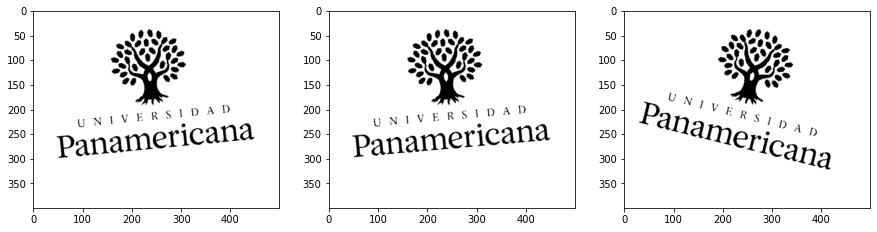

In [186]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(ChromosomeToImage(survivorPop[0][0]), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(ChromosomeToImage(survivorPop[1][0]), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(ChromosomeToImage(survivorPop[2][0]), cmap='gray')

In [187]:
def EvolutiveStrategies(max_generations=200,population_size=100):
    p=GetPopulation(population_size)
    elite=p[0]
    ng=0
    while(ng<max_generations and elite[1]>100):
        child_generation=[]
        for i in range(0,int(population_size*1.5)):
            a = p[random.randint(0,population_size-1)]
            b = p[random.randint(0,population_size-1)]
            c= Crossover(a,b)
            #Mutation(c)
            child_generation.append(c)
        p = SurvivorChromosomes(p,child_generation,population_size)
        elite=p[0]
        ng+=1
    
    return elite
        
        

In [190]:
e = EvolutiveStrategies()
print(e)
res = ChromosomeToImage(e[0])

[array([250.        , 200.        ,  29.69237514,   1.        ,
          0.        ,   0.        ,   2.26899433,   0.        ]) 640314]


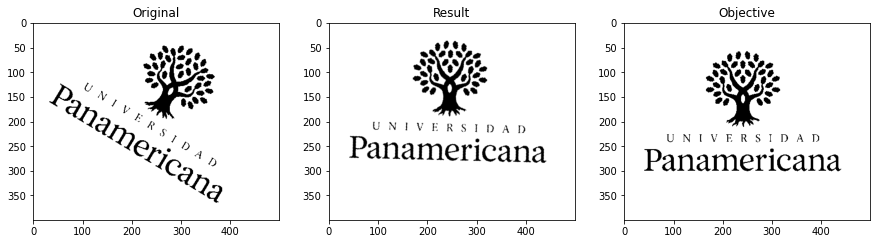

In [191]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(inputImage, cmap='gray')
plt.subplot(1,3,2)
plt.title("Result")
plt.imshow(res, cmap='gray')
plt.subplot(1,3,3)
plt.title("Objective")
plt.imshow(objectiveImage, cmap='gray')

# Rafael Andrade and José Luis Lobera